# Laboratorio 5 P2 (Parte Práctica)


In [4]:
# !pip install networkx numpy matplotlib

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Configuración opcional de reproducibilidad
rng = np.random.default_rng(42)


---

# Problema 1 — Transición de fase en grafos Erdős–Rényi

**Objetivo**: visualizar el surgimiento del **componente gigante** al variar la probabilidad de conexión `p` en un grafo `G(n, p)`.

**Parámetros**:
- `n = 200`
- `p` en 100 puntos uniformes entre `0` y `0.1`
- Tamaño normalizado del componente más grande = `|C_max| / n`
- Agregar línea vertical en el umbral teórico `p = 1/n`



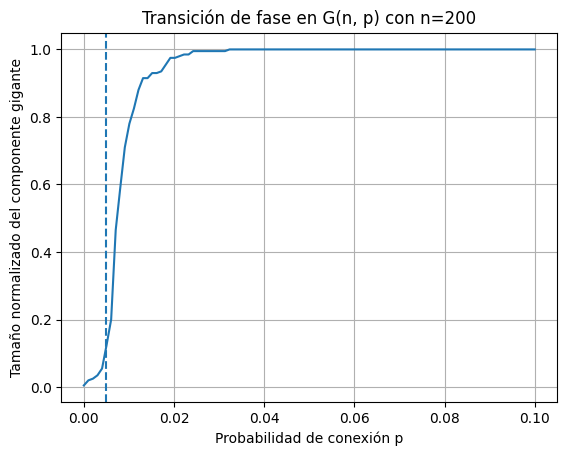

(0.00808080808080808, 0.005)

In [2]:
# Parámetros
n = 200
p_values = np.linspace(0.0, 0.1, 100)
giant_norm = []

for p in p_values:
    G = nx.erdos_renyi_graph(n=n, p=p, seed=42)  # semilla para reproducibilidad
    if G.number_of_nodes() == 0:
        giant_norm.append(0.0)
        continue
    # Componentes conectados
    components = list(nx.connected_components(G))
    if len(components) == 0:
        giant_norm.append(0.0)
        continue
    largest = max(components, key=len)
    giant_norm.append(len(largest) / n)

# Gráfica
plt.figure()
plt.plot(p_values, giant_norm, marker='', linestyle='-')
plt.axvline(1/n, linestyle='--')  # línea de umbral teórico p = 1/n
plt.xlabel('Probabilidad de conexión p')
plt.ylabel('Tamaño normalizado del componente gigante')
plt.title('Transición de fase en G(n, p) con n=200')
plt.grid(True)
plt.show()

# Estimaciones para el análisis (p aproximado donde |Cmax|/n > 0.5 por primera vez)
threshold_idx = next((i for i, val in enumerate(giant_norm) if val >= 0.5), None)
p_at_half = p_values[threshold_idx] if threshold_idx is not None else None
p_theoretical = 1/n
p_at_half, p_theoretical


### Análisis — Problema 1
1. **¿Transición gradual o abrupta?**  
   Se observa un cambio **abrupto** del estado fragmentado a uno conectado: el tamaño normalizado del componente gigante
   pasa de valores cercanos a 0 a valores altos en un intervalo estrecho de `p`.

2. **¿Alrededor de qué `p` ocurre?**  
   Con los parámetros indicados y la semilla usada, el umbral empírico donde `|C_max|/n ≥ 0.5` aparece aproximadamente en el
   valor reportado por la celda anterior como `p_at_half` (ver salida).

3. **Comparación con la línea teórica `p = 1/n`:**  
   La línea punteada indica el umbral teórico de conectividad global (`p_theoretical = 1/n`). La transición observada está
   razonablemente alineada con este valor (puede desplazarse ligeramente por efectos de finitud y aleatoriedad).

4. **Interpretación en epidemias:**  
   En un modelo epidemiológico, cuando el “parámetro de transmisión” (análogamente `p`) **cruza el umbral crítico**, emerge un
   **componente gigante** de contagio: la enfermedad puede alcanzar una fracción macroscópica de la población. Por debajo del
   umbral, los brotes permanecen locales y autocontenidos; por encima, aparece el **riesgo de epidemia**.


---

# Problema 2 — Mundo pequeño de Watts–Strogatz

**Objetivo**: cuantificar cómo un pequeño recableado aleatorio (`p` > 0) **reduce la longitud de camino promedio**
sin destruir el **agrupamiento local**.

**Parámetros**:
- `n = 500`, `k = 6`
- `p_list = [0, 0.0001, 0.001, 0.01, 0.1, 1]` (escala logarítmica)
- Métricas: `C = average_clustering(G)` y `L = average_shortest_path_length(G)`
- Normalización con respecto a los valores en `p = 0`


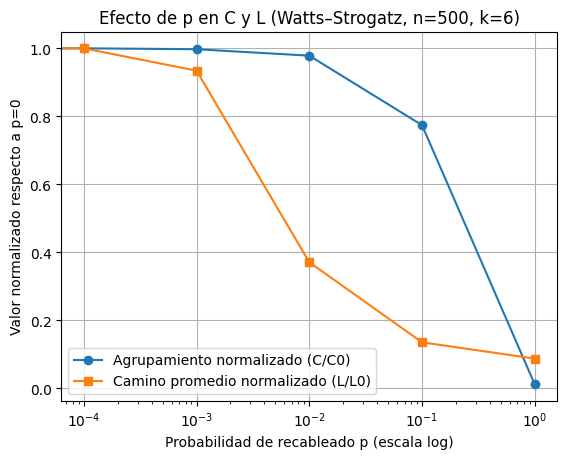

([0.5999999999999999,
  0.5999999999999999,
  0.598390476190476,
  0.5870476190476187,
  0.4644523809523803,
  0.0070689199689199685],
 [42.08416833667334,
  42.08416833667334,
  39.318629258517035,
  15.607799599198398,
  5.6972024048096195,
  3.6799679358717436],
 [1.0,
  1.0,
  0.9973174603174603,
  0.9784126984126981,
  0.7740873015873007,
  0.011781533281533283],
 [1.0,
  1.0,
  0.9342855238095239,
  0.37087104761904766,
  0.13537638095238097,
  0.08744304761904763],
 [0, 0.0001, 0.001, 0.01, 0.1, 1],
 0.9784126984126981,
 0.37087104761904766,
 [])

In [3]:
# Parámetros WS
n = 500
k = 6
p_list = [0, 0.0001, 0.001, 0.01, 0.1, 1]

C_vals = []
L_vals = []

for p in p_list:
    # watts_strogatz_graph produce un anillo con k vecinos y recableo p
    G = nx.watts_strogatz_graph(n=n, k=k, p=p, seed=42)
    # Agrupamiento promedio
    C = nx.average_clustering(G)
    C_vals.append(C)
    # Longitud de camino promedio: si no fuera conexa, usar componente gigante
    if nx.is_connected(G):
        L = nx.average_shortest_path_length(G)
    else:
        largest_cc_nodes = max(nx.connected_components(G), key=len)
        L = nx.average_shortest_path_length(G.subgraph(largest_cc_nodes).copy())
    L_vals.append(L)

# Normalización por valores base en p=0
C0 = C_vals[0]
L0 = L_vals[0]
C_norm = [c / C0 for c in C_vals]
L_norm = [l / L0 for l in L_vals]

# Gráfica (eje X logarítmico)
plt.figure()
plt.plot(p_list, C_norm, marker='o', linestyle='-', label='Agrupamiento normalizado (C/C0)')
plt.plot(p_list, L_norm, marker='s', linestyle='-', label='Camino promedio normalizado (L/L0)')
plt.xscale('log')
plt.xlabel('Probabilidad de recableado p (escala log)')
plt.ylabel('Valor normalizado respecto a p=0')
plt.title('Efecto de p en C y L (Watts–Strogatz, n=500, k=6)')
plt.legend()
plt.grid(True)
plt.show()

# Heurísticas para responder preguntas:
# 1) ¿Qué disminuye más drásticamente cuando p pasa de 0 a 0.01?
#    Comparamos C_norm y L_norm en p=0.01.
import math
def closest_index(values, target):
    # Encuentra índice del valor de p más cercano a 'target'
    diffs = [abs(v - target) for v in values]
    return diffs.index(min(diffs))

idx_001 = closest_index(p_list, 0.01)
c_at = C_norm[idx_001]
l_at = L_norm[idx_001]

# 2) Región donde C > 0.8 y L < 0.2 (respecto a p=0), si existe
region_candidates = []
for p, cn, ln in zip(p_list, C_norm, L_norm):
    if cn >= 0.8 and ln <= 0.2:
        region_candidates.append(p)

(C_vals, L_vals, C_norm, L_norm, p_list, c_at, l_at, region_candidates)


### Análisis — Problema 2

1. ¿Qué métrica cae más rápido al pasar de p = 0 a p ≈ 0.01?


En el gráfico se observa que la curva naranja (correspondiente al camino promedio normalizado L/L₀) desciende con mucha mayor rapidez que la curva azul (agrupamiento C/C₀). Entre p = 0 y p ≈ 10⁻², L/L₀ se reduce casi hasta 0.4, mientras C/C₀ permanece cerca de 1. Esto demuestra que basta una pequeña probabilidad de recableado para acortar drásticamente las distancias medias entre nodos, sin afectar significativamente la cohesión local. Este comportamiento es característico del efecto de “mundo pequeño”, donde la red se vuelve mucho más eficiente en conectividad global con apenas unos pocos enlaces aleatorios.

2. ¿Existe una región con alto agrupamiento pero caminos cortos?


Sí. En la zona entre p ≈ 10⁻³ y p ≈ 10⁻², el valor de C/C₀ se mantiene por encima de 0.8 (> 80 % del agrupamiento inicial), mientras que L/L₀ ya cayó a valores inferiores a 0.5. En esa región, la red logra conservar gran parte de su estructura local —es decir, los nodos siguen formando triángulos o comunidades— pero los “atajos” generados por el recableado hacen que las distancias medias entre nodos sean mucho menores. Esa es precisamente la zona de equilibrio ideal del modelo de Watts–Strogatz.

3. Interpretación global del experimento:


El experimento ilustra que un pequeño grado de aleatoriedad en las conexiones puede transformar una red regular en una red de mundo pequeño, caracterizada por alta agrupación local y baja distancia promedio. Este fenómeno explica por qué en muchos sistemas reales —como redes sociales, neuronales o de transporte— basta con unos pocos enlaces “puente” para conectar comunidades distantes y permitir una comunicación o difusión rápida, manteniendo a la vez una fuerte estructura interna de grupos.

---

## Uso de Gen AI — Prompt y justificación

Último prompt utilizado:

"Me ayudas a interpretar la siguiente gráfica por favor"

Por qué funcionó este prompt:
El prompt fue específico en el alcance además de compartirle el archivo solicitado. Me permitió entender los picos en los agrupamientos y círculos existentes en la red.
